In [53]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff
console = genjax.pretty(show_locals=False)

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
root_poses = jnp.tile(contact_plane[None, ...],(4,1,1))
all_box_dims = b.RENDERER.model_box_dims

In [5]:
from genjax.generative_functions.distributions import ExactDensity
import bayes3d as b
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import genjax

@dataclass
class GaussianVMFPose(ExactDensity):
    def sample(self, key, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_sample(key, pose_mean, var, concentration)

    def logpdf(self, pose, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_logpdf(pose, pose_mean, var, concentration)

@dataclass
class ImageLikelihood(ExactDensity):
    def sample(self, key, img, variance, outlier_prob, outlier_volume):
        return img

    def logpdf(self, image, s, variance, outlier_prob, outlier_volume):
        return b.threedp3_likelihood(image, s, variance, outlier_prob, outlier_volume,5)

@dataclass
class ContactParamsUniform(ExactDensity):
    def sample(self, key, low, high):
        return jax.random.uniform(key, shape=(3,)).reshape(-1,1) * (high - low) + low

    def logpdf(self, sampled_val, low, high, **kwargs):
        valid = ((low <= sampled_val) & (sampled_val <= high))
        log_probs = jnp.log((valid * 1.0) * (jnp.ones_like(sampled_val) / (high-low)))
        return log_probs.sum()

@dataclass
class ContactParamsUniform(ExactDensity):
    def sample(self, key, low, high, arr):
        return jax.random.uniform(key, shape=arr.shape).reshape(-1,1) * (high - low) + low

    def logpdf(self, sampled_val, low, high, arr,**kwargs):
        valid = ((low < sampled_val) & (sampled_val < high))
        log_probs = jnp.log((valid * 1.0) * (jnp.ones_like(sampled_val) / (high-low)))
        return log_probs.sum()

@dataclass
class UniformDiscreteArray(ExactDensity):
    def sample(self, key, vals, arr):
        return jax.random.choice(key, vals, shape=arr.shape)

    def logpdf(self, sampled_val, vals, arr,**kwargs):
        return jnp.log(1.0 / (vals.shape[0])) * arr.shape[0]

@dataclass
class UniformDiscrete(ExactDensity):
    def sample(self, key, vals):
        return jax.random.choice(key, vals)

    def logpdf(self, sampled_val, vals,**kwargs):
        return jnp.log(1.0 / (vals.shape[0]))


gaussian_vmf_pose = GaussianVMFPose()
image_likelihood = ImageLikelihood()
contact_params_uniform = ContactParamsUniform()
uniform_discrete = UniformDiscrete()
uniform_discrete_array = UniformDiscreteArray()



@genjax.gen
def tabletop_model(array, root_poses, all_box_dims):
    indices = jnp.array([-1])
    for i in range(array.shape[0]):
        index = uniform_discrete(jnp.arange(0,22)) @ f"id_{i}"
        indices = jnp.concatenate([indices, jnp.array([index])])
    indices = indices[1:]
        
    contact_params = contact_params_uniform(jnp.array([[-0.2,-0.2, -2*jnp.pi]]), jnp.array([[0.2,0.2, 2*jnp.pi]]), array) @ "contact_params"
    parents = uniform_discrete_array(jnp.arange(-1,1), array) @ "parents"
    face_parent = uniform_discrete_array(jnp.arange(2,3), array) @ "face_parent"
    face_child = uniform_discrete_array(jnp.arange(3,4), array) @ "face_child"
    box_dims = all_box_dims[indices]
    poses = b.scene_graph.poses_from_scene_graph(root_poses, box_dims, parents, contact_params, face_parent, face_child)
    rendered = b.RENDERER.render_jax(
        poses , indices
    )[...,:3]

    variance = genjax.distributions.tfp_uniform(0.00001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.00001, 0.01) @ "outlier_prob"
    image_likelihood(rendered, variance, outlier_prob, 100.0) @ "image"
    return rendered, indices, poses

def viz_trace_meshcat(trace, colors=None):
    b.clear()
    key = jax.random.PRNGKey(10)
    b.show_cloud("1", trace["image"].reshape(-1,3))
    b.show_cloud("2", trace.get_retval()[0].reshape(-1,3),color=b.RED)
    # noisy_point_cloud_image = jax.random.multivariate_normal(
    #     key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
    # )
    # b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=b.RED)
    indices = trace.get_retval()[1]
    print(indices)
    if colors is None:
        colors = b.viz.distinct_colors(max(10, len(indices)))
    for i in range(len(indices)):
        b.show_trimesh(f"obj_{i}", b.RENDERER.meshes[indices[i]],color=colors[i])
        b.set_pose(f"obj_{i}", trace.get_retval()[2][i])

simulate_jit = jax.jit(tabletop_model.simulate)
update_jit = jax.jit(tabletop_model.update)
importance_jit = jax.jit(tabletop_model.importance)
importance_parallel_jit = jax.jit(jax.vmap(tabletop_model.importance, in_axes=(0, None, None)))

enumerator_trace = lambda trace, c, v, o : trace.update(
    key,
    genjax.choice_map({
        "contact_params": c, 
        "variance": v,
        "outlier_prob": o,
    }),
    jtu.tree_map(lambda v: Diff(v, NoChange), trace.args),
)[1][2]
enumerator_trace_jit = jax.jit(enumerator_trace)
enumerator_trace_vmap = jax.vmap(jax.vmap(jax.vmap(enumerator_trace, in_axes=(None, None, None, 0)), in_axes=(None, None, 0, None)), in_axes=(None, 0, None, None))
enumerator_trace_vmap_jit = jax.jit(enumerator_trace_vmap)

enumerator_score = lambda trace, c, v, o: enumerator_trace(trace, c, v, o).get_score()
enumerator_score_jit = jax.jit(enumerator_score)
enumerator_score_vmap = jax.vmap(jax.vmap(jax.vmap(enumerator_score, in_axes=(None, None, None, 0)), in_axes=(None, None, 0, None)), in_axes=(None, 0, None, None))
enumerator_score_vmap_jit = jax.jit(enumerator_score_vmap)

In [6]:
key = jax.random.PRNGKey(10)

[21 12  6]
[-1  0  0]
[21 12  6]
-7908.241


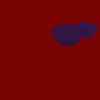

In [7]:
key, (_,gt_trace) = importance_jit(key, genjax.choice_map({
    "parents": jnp.array([-1, 0, 0]), 
    "id_0": jnp.int32(21)
}), (jnp.arange(3), root_poses[:3], all_box_dims,))
viz_trace_meshcat(gt_trace)
print(gt_trace["parents"])
print(gt_trace.get_retval()[1])
print(gt_trace.get_score())
# print(gt_trace["contact_params"])
# print(gt_trace["indices"])
observed_image = gt_trace.get_retval()[0]
b.get_depth_image(observed_image[...,2])

In [8]:
VARIANCE_GRID = jnp.array([0.00001, 0.0001, 0.001])
OUTLIER_GRID = jnp.array([0.01, 0.001, 0.0001])
OUTLIER_VOLUME = 100.0

grid_params = [
    (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.05, jnp.pi/5, (11,11,3)),
    (0.02, jnp.pi/5, (11,11,11)), (0.02, jnp.pi, (5,5,51))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

key = jax.random.PRNGKey(100)

In [9]:
grid = contact_param_gridding_schedule[2]
grid[jnp.abs(grid).sum(1).argmin()]

Array([1.8626451e-09, 1.8626451e-09, 0.0000000e+00], dtype=float32)

In [45]:
N = 1
obj_id = 3
key, (_,trace) = importance_jit(key, genjax.choice_map({
    "parents": jnp.array([-1]), 
    "id_0": jnp.int32(21),
    "contact_params": jnp.zeros((1,3)),
    "image": observed_image,
    "variance": VARIANCE_GRID[0] ,
    "outlier_prob": OUTLIER_GRID[0] ,
}), (jnp.arange(N), root_poses[:N], all_box_dims,))
print(trace.get_score())
print(trace["parents"])
viz_trace_meshcat(trace)

41844.33
[-1]
[21]


In [37]:
def c2f_contact_update(trace_, object_index, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_deltas = contact_param_gridding_schedule[c2f_iter]
    contact_param_grid = contact_param_deltas + trace_["contact_params"][object_index]
    contact_param_full = jnp.tile(trace_["contact_params"][None,...], (contact_param_grid.shape[0],1,1))
    contact_param_full = contact_param_full.at[:,object_index].set(contact_param_grid)
    scores = enumerator_score_vmap(trace_, contact_param_full, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)

    return contact_param_full[i], VARIANCE_GRID[j], OUTLIER_GRID[k]

c2f_contact_update_jit = jax.jit(c2f_contact_update)


In [38]:
%%time

all_paths = []
for obj_id in tqdm(range(len(b.RENDERER.meshes))):
    N = len(trace["parents"]) + 1
    object_index = N-1
    key, (_,trace_) = update_jit(trace, key, genjax.choice_map({
        "parents": jnp.concatenate([trace["parents"], jnp.array([0])]),
        f"id_{N-1}": jnp.int32(obj_id),
        "contact_params": jnp.concatenate([trace["contact_params"],jnp.zeros((1,3))]),
        "image": observed_image,
        "variance": VARIANCE_GRID[0] ,
        "outlier_prob": OUTLIER_GRID[0] ,
    }), (jnp.arange(N), root_poses[:N], all_box_dims,))

    object_number = trace["contact_params"].shape[0] - 1
    p = None
    trace_path = []
    trace_path.append(trace_)
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact, variance, outlier = c2f_contact_update_jit(trace_, object_index, contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        trace_ = enumerator_trace_jit(trace_, contact, variance, outlier)
        # contact_param_deltas = contact_param_gridding_schedule[c2f_iter]
        # contact_param_grid = contact_param_deltas + trace_["contact_params"][object_index]
        # contact_param_full = jnp.tile(trace_["contact_params"][None,...], (contact_param_grid.shape[0],1,1))
        # contact_param_full = contact_param_full.at[:,object_index].set(contact_param_grid)
        # scores = enumerator_score_vmap_jit(trace_, contact_param_full, VARIANCE_GRID, OUTLIER_GRID)
        # i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
        # print(i,j,k)
        # trace_ = enumerator_trace_jit(trace_, contact_param_full[i], VARIANCE_GRID[j], OUTLIER_GRID[k])
        trace_path.append(trace_)
    all_paths.append(
        trace_path
    )


100%|██████████| 22/22 [00:29<00:00,  1.33s/it]

CPU times: user 27.5 s, sys: 5.4 s, total: 32.9 s
Wall time: 29.3 s


In [57]:
jtu.tree_map(lambda v: Diff(v, UnknownChange), (jnp.arange(N), root_poses[:N], all_box_dims,))

(Diff(...), Diff(...), Diff(...))

In [64]:
diffs = jtu.tree_map(lambda v: Diff(v, NoChange), trace.args)

In [69]:
N = 3
diffs = jtu.tree_map(lambda v: Diff(v, UnknownChange), (jnp.arange(N), root_poses[:N], all_box_dims,))
key, (_, weight, new, discard) = update_jit(
    key, trace, trace.get_choices(), diffs)
    

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_87139/1004371134.py:3 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_87139/1004371134.py'                        │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/traceback_util.py:166 in            │
│ reraise_with_filtered_traceback                                                                  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:238 in cache_miss           │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:180 in _python_pjit_helper  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/api.py:311 in infer_params          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:480 in common_infer_params  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:918 in _pjit_jaxpr          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/linear_util.py:322 in memoized_fun  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:874 in _create_pjit_jaxpr   │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/profiler.py:314 in wrapper          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/interpreters/partial_eval.py:2049   │
│ in trace_to_jaxpr_dynamic                                                                        │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/interpreters/partial_eval.py:2066   │
│ in trace_to_subjaxpr_dynamic                                                                     │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/linear_util.py:166 in call_wrapped  │
│ <@beartype(genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction.upd │
│ ate) at 0x7fb0a112d9d0>:92 in update                                                             │
│                                                                                                  │
│ /home/ubuntu/genjax/src/genjax/_src/generative_functions/builtin/builtin_gen_fn.py:188 in update │
│                                                                                                  │
│   185 │   │   │   │   discard,                                                                   │
│   186 │   │   │   ),                                                                             │
│   187 │   │   │   cache,                                                                         │
│ ❱ 188 │   │   ) = update_transform(self.source, **kwargs)(k

In [66]:
jtu.tree_map(lambda v: Diff(v, UnknownChange), (jnp.arange(N), root_poses[:N], all_box_dims,))

(Diff(...), Diff(...), Diff(...))

In [60]:
N = len(trace["parents"]) + 1
object_index = N-1
key, (_,trace_) = update_jit(trace, key, genjax.choice_map({
    # "parents": jnp.concatenate([trace["parents"], jnp.array([0])]),
    # f"id_{N-1}": jnp.int32(obj_id),
    # "contact_params": jnp.concatenate([trace["contact_params"],jnp.zeros((1,3))]),
    # "image": observed_image,
    # "variance": VARIANCE_GRID[0] ,
    # "outlier_prob": OUTLIER_GRID[0] ,
}), jtu.tree_map(lambda v: Diff(v, UnknownChange), (jnp.arange(N), root_poses[:N], all_box_dims,)))

# viz_trace_meshcat(trace_)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_87139/2938825139.py:3 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_87139/2938825139.py'                        │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/traceback_util.py:166 in            │
│ reraise_with_filtered_traceback                                                                  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:238 in cache_miss           │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:180 in _python_pjit_helper  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/api.py:311 in infer_params          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:480 in common_infer_params  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:918 in _pjit_jaxpr          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/linear_util.py:322 in memoized_fun  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:874 in _create_pjit_jaxpr   │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/profiler.py:314 in wrapper          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/interpreters/partial_eval.py:2049   │
│ in trace_to_jaxpr_dynamic                                                                        │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/interpreters/partial_eval.py:2066   │
│ in trace_to_subjaxpr_dynamic                                                                     │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/linear_util.py:166 in call_wrapped  │
│ <@beartype(genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction.upd │
│ ate) at 0x7fb0a112d9d0>:26 in update                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
BeartypeCallHintParamViolation: @beartyped 
genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction.update() parameter 
key="BuiltinTrace(gen_fn=BuiltinGenerativeFunction(source=PytreeClosure(callable=<function table..._ violates type 
hint <class 'jaxtyping.UInt[Array, '...']'>, as <protocol 
"genjax._src.generative_functions.builtin.builtin_datatypes.BuiltinTrace"> 
"BuiltinTrace(gen_fn=BuiltinGenerativeFunction(source=PytreeClosure(callable=<function table..._ not instance of 
<class "jaxtyping.UInt[Array, '...']">.

In [39]:
scores = jnp.array([t[-1].get_score() for t in all_paths])
print(scores)
normalized_scores = b.utils.normalize_log_scores(scores)
# print(["{:0.3f}".format(n) for n in normalized_scores])
order = jnp.argsort(-scores)
# print(order)
new_trace = all_paths[jnp.argmax(scores)][-1]
trace = new_trace
    # b.viz_trace_meshcat(trace)


viz_trace_meshcat(trace)

[108778.97   93649.805 119708.88  118708.75  103071.55  109742.83
 110568.07  125989.86   87244.36  111722.625  97362.305  65739.805
 105153.484  96690.02  119782.2   102568.375 104536.81  123535.45
 110105.94   96295.36   98777.516 118756.81 ]
[7 7]


In [41]:
trace.get_retval()[1]

Array([7, 7], dtype=int32)

In [135]:
scores[12]

Array(42515.297, dtype=float32)

In [134]:
viz_trace_meshcat(all_paths[12][-1])

[21 12]
